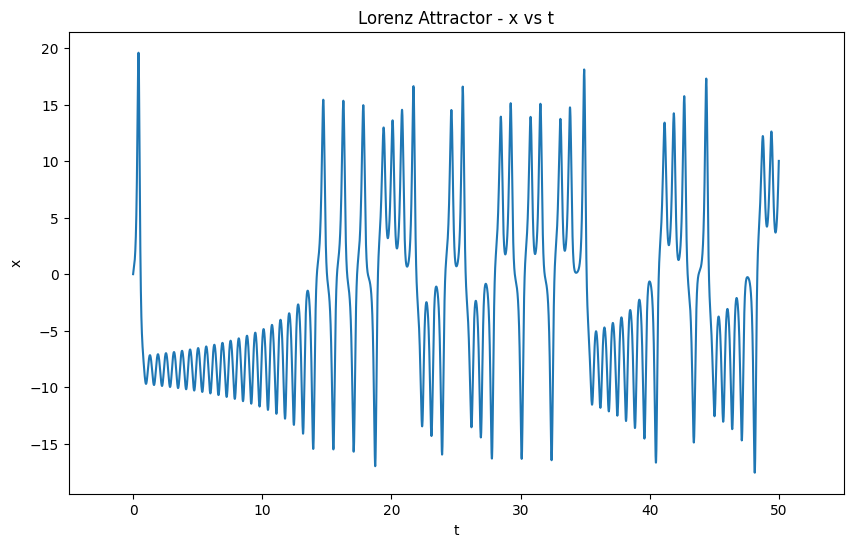

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# Define the system of ODEs
def lorenz(state,t):
    sigma = 10
    rho = 28
    beta = 8/3
    x, y, z = state  # Unpack the state vector
    return sigma*(y - x), x*(rho - z) - y, x*y - beta*z  # Derivatives

state0 = [0.0, 1.0, 1.0]  # Initial condition
t = np.arange(0.0, 50.0, 0.01)  # Time grid

# Solve the ODEs
state = odeint(lorenz, state0, t)

# Save the t and data in pkl format
data = np.concatenate((t.reshape(-1,1), state), axis=1)
df = pd.DataFrame(data, columns=['t','x','y','z'])

# Plot x against t
plt.figure(figsize=(10,6))
plt.plot(df['t'], df['x'])
plt.xlabel('t')
plt.xlim(-5,55)
plt.ylabel('x')
plt.title('Lorenz Attractor - x vs t')
plt.show()


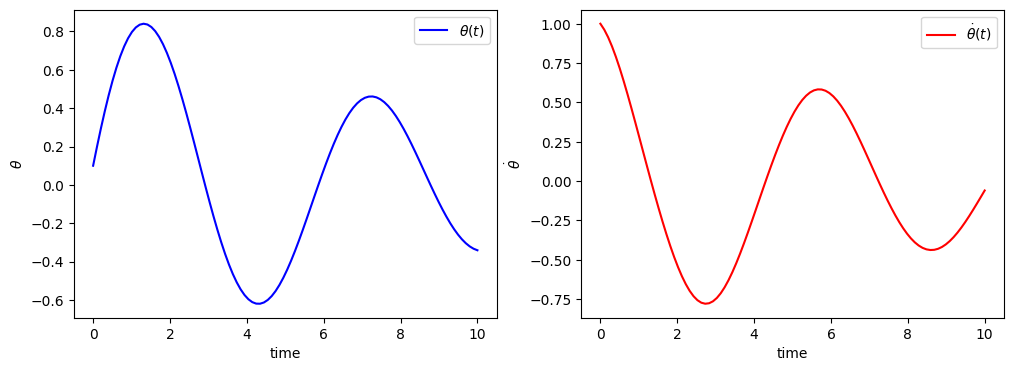

In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameters
m = 1  # pendulum's mass
l = 1  # pendulum's length
I = (1 / 12) * m * (l ** 2)  # moment of inertia
b = 0.01  # friction coefficient
g = 9.81  # acceleration due to gravity

# pendulum system
def pendulum_system(y, t, u):
    theta, theta_dot = y
    dydt = [theta_dot, (1 / (4*m*l**2 + I)) * (u(t,theta_dot) - b*theta_dot - 0.5*m*l*g*np.sin(theta))]
    return dydt

# control torque
def u(t, theta_dot):
    #theta, theta_dot = y
    return -0.8 * theta_dot  # replace with the actual control torque function
    #return np.sin(t/2)

# initial condition
y0 = [0.1, 1]  # [theta, theta_dot] at t=0

# time points
t = np.linspace(0, 10, 100)

# solve ODE
y = odeint(pendulum_system, y0, t, args=(u,))

# plot results in a 1 by 2 figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(t, y[:, 0], 'b-', label=r'$\theta(t)$')
ax1.set_xlabel('time')
ax1.set_ylabel(r'$\theta$')
ax1.legend(loc='best')
ax2.plot(t, y[:, 1], 'r-', label=r'$\dot{\theta}(t)$')
ax2.set_xlabel('time')
ax2.set_ylabel(r'$\dot{\theta}$')
ax2.legend(loc='best')
plt.show()


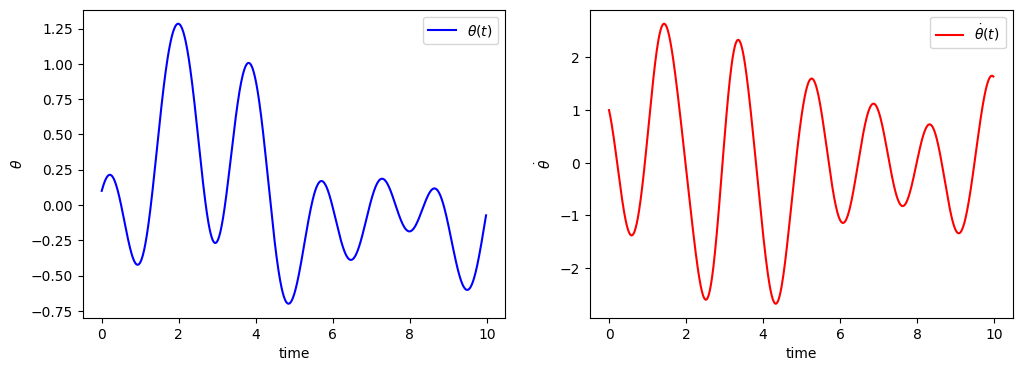

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from scipy.interpolate import CubicSpline

# Correlation function
def rho(h, a=1, nu=1):
    return np.exp(- (h / a)**(2*nu))

# Space discretization
x = np.linspace(-10, 10, 2000)
dx = x[1] - x[0]

# Distance matrix
H = np.abs(x[:, np.newaxis] - x)

# Covariance matrix
sigma = rho(H)
sigma += 1e-6 * np.eye(sigma.shape[0])

# Cholesky factorization
L = cholesky(sigma, lower=True)

# Independent standard Gaussian random variables
z = np.random.normal(size=x.size)

# Gaussian random field
y = np.dot(L, z)
spline = CubicSpline(x, y)

class dotdict(dict):
    """dot.notation access to dictionary attributes."""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def runge_kutta(f, x, u, h):
    """f(x, u) -> next_x."""
    k1 = f(x, u)
    k2 = f(x + 0.5 * h * k1, u)
    k3 = f(x + 0.5 * h * k2, u)
    k4 = f(x + h * k3, u)
    next_x = x + (k1 + 2 * k2 + 2 * k3 + k4) * h / 6
    return next_x

def integrate(method, f, control, x0, h, N):
    soln = dotdict()
    soln.x = []
    soln.t = []
    soln.u = []

    x = x0

    t = 0 * h
    u = control(t, x)
    soln.x.append(x)


    for n in range(1, N):
        # log previous control
        soln.t.append(t)
        soln.u.append(u)
        # compute next state
        x_next = runge_kutta(f, x, u, h)
        # log next state
        soln.x.append(x_next)
        x = x_next
        t = n * h
        u = control(t, x)

    soln.x = np.vstack(soln.x)
    soln.t = np.vstack(soln.t)
    soln.u = np.vstack(soln.u)

    return soln

# define the pendulu's vector field
m = 1
l = 1
I = (1 / 12) * m * (l ** 2)
b = 0.01
g = 9.81
def pendulum(x, u):
    theta, omega = x
    f_theta = omega
    f_omega = (1 / (0.25 * m * (l ** 2) + I)) * (u - b * omega - 0.5 * m * l * g * np.sin(theta))
    return np.array([f_theta, f_omega])

# for testing, we solve the following:
T = 10
h = 0.01
N = int(T/h)
x = np.array([0.1,1.0])

def control(t, x):
    theta, theta_dot = x
    #return np.sin(t/2)         # oscillatory response
    #return t/100
    #return -0.80 * theta_dot    # stable response
    return spline(t)

soln = integrate(runge_kutta, pendulum, control, x, h, N)

# plot results in a 1 by 2 figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(soln.t, soln.x[:-1, 0], 'b-', label=r'$\theta(t)$')
ax1.set_xlabel('time')
ax1.set_ylabel(r'$\theta$')
ax1.legend(loc='best')
ax2.plot(soln.t, soln.x[:-1, 1], 'r-', label=r'$\dot{\theta}(t)$')
ax2.set_xlabel('time')
ax2.set_ylabel(r'$\dot{\theta}$')
ax2.legend(loc='best')
plt.show()


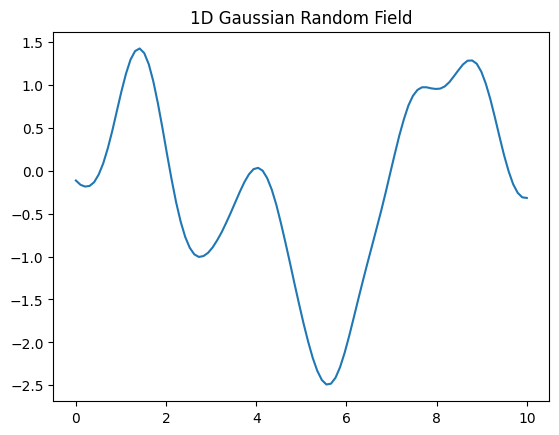

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

# Correlation function
def rho(h, a=1, nu=1):
    return np.exp(- (h / a)**(2*nu))

# Space discretization
x = np.linspace(0, 10, 100)
dx = x[1] - x[0]

# Distance matrix
H = np.abs(x[:, np.newaxis] - x)

# Covariance matrix
sigma = rho(H)
sigma += 1e-6 * np.eye(sigma.shape[0])

# Cholesky factorization
L = cholesky(sigma, lower=True)

# Independent standard Gaussian random variables
z = np.random.normal(size=x.size)

# Gaussian random field
y = np.dot(L, z)

# Plot
plt.plot(x, y)
plt.title("1D Gaussian Random Field")
plt.show()


In [8]:
import numpy as np
x = np.arange(0.01, 10)
print(np.log(x.mean()))
print(np.log(x.std()))
print((np.log(x)-np.log(x.mean()))/np.log(x.std()))


1.5062971535145868
1.0551066001732947
[-5.79227477 -1.41819492 -0.76595335 -0.38323812 -0.11136876  0.09964753
  0.27213136  0.41800568  0.54439391  0.65589384]
